# Linear Regression

axtaylor

In [21]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
from scipy.stats import t as t_dist

### Sample Dataset - Statistics Canada, General Social Survey

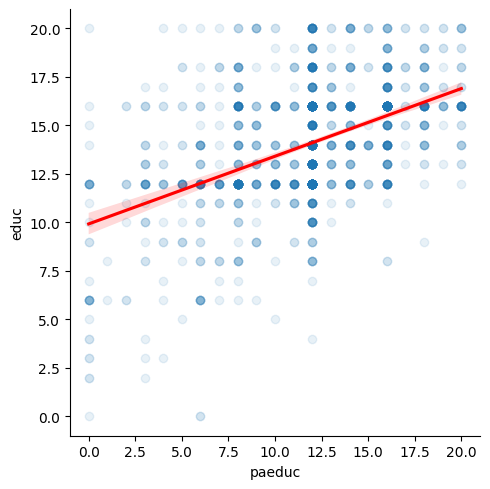

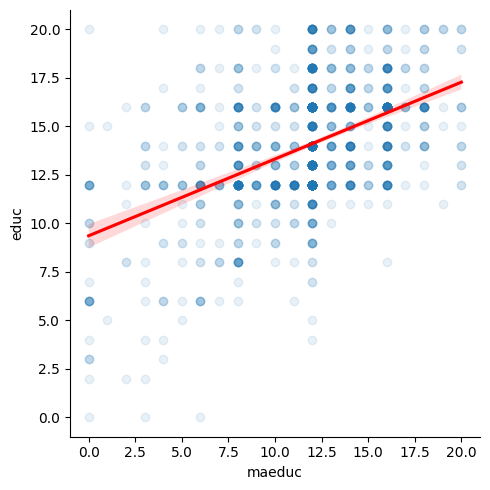

In [2]:
gss = pd.read_csv('../Datasets/gss.csv', low_memory=False) 
gss_2010 = gss.loc[gss["yrint"] == 2010].dropna(subset=['paeduc', 'maeduc', 'educ'])

X, y = gss_2010[['paeduc', 'maeduc']], gss_2010['educ']

sns.lmplot(x="paeduc", y="educ", data=gss_2010, scatter_kws={'alpha':0.1}, line_kws={'color': 'red'})
sns.lmplot(x="maeduc", y="educ", data=gss_2010, scatter_kws={'alpha':0.1}, line_kws={'color': 'red'})
plt.tight_layout()
plt.show()

### Linear Model - OLS Statsmodels Library Approach


Equation to solve for known values in the model:

$$y = \beta_0 + \beta_ix_i + \epsilon$$

Equation to predict unknown values with:

$$\widehat{y} = \hat{\beta_0} + \hat{\beta_i}x_i$$

$\beta$: Population coefficient (The true explanatory variable, precise value unknown.)

$\hat{\beta}$: Sample estimate coefficient (Estimate of $\beta$ based on the training data)

$y$: Observed dependent variable in the data 

$\widehat{y}$: Predicted dependent variable from given input(s)

In [3]:
# Using statsmodels.api
sm_model = sm.OLS(y, sm.add_constant(X)).fit()
print(sm_model.summary())

                            OLS Regression Results                            
Dep. Variable:                   educ   R-squared:                       0.260
Model:                            OLS   Adj. R-squared:                  0.259
Method:                 Least Squares   F-statistic:                     245.6
Date:                Sun, 21 Sep 2025   Prob (F-statistic):           3.57e-92
Time:                        17:52:53   Log-Likelihood:                -3378.5
No. Observations:                1404   AIC:                             6763.
Df Residuals:                    1401   BIC:                             6779.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          8.8861      0.242     36.654      0.0

In [4]:
print(f"SSR: {sm_model.ssr:.4f}")
print(f"Total Sum of Squares: {sm_model.centered_tss:.4f}")
print(f"Mean Squared Error: {sm_model.mse_resid:.4f}")
print(f"Root MSE: {np.sqrt(sm_model.mse_resid):.4f}")
print(f"R-squared: {sm_model.rsquared:.4f}")

SSR: 10115.9844
Total Sum of Squares: 13663.2707
Mean Squared Error: 7.2205
Root MSE: 2.6871
R-squared: 0.2596


In [5]:
# Using statsmodels.api to query prediction info to the likes of marginaleffects in R

def statsmodels_me():
    coef1 = [0]
    coef2 = [0]
    hypothesis = 8.8861 # Default = 0

    for i, j in zip(coef1, coef2):
        new_data = pd.DataFrame({'paeduc': [i], 'maeduc': [j]}) 
        new_data = sm.add_constant(new_data, has_constant='add')

        sm_pred = sm_model.get_prediction(new_data)
        sm_summary = sm_pred.summary_frame(alpha=0.05)

        t_stat = (sm_summary['mean'].iloc[0] - hypothesis)/sm_summary['mean_se'].iloc[0]
        p_val = 2 * (1 - stats.t.cdf(abs(t_stat), sm_model.df_resid))

        print(f"{sm_summary}\nT statistic \n{t_stat:.4f}\np > |t|\n{p_val:.4f}\n")

statsmodels_me()

       mean  mean_se  mean_ci_lower  mean_ci_upper  obs_ci_lower  obs_ci_upper
0  8.886091  0.24243       8.410526       9.361655      3.593494     14.178687
T statistic 
-0.0000
p > |t|
1.0000



### Linear Model - OLS Simple Approach without Matrix Multiplication 

Slope:

$$\hat{\beta_1}=\frac{\sum(x_i - \bar{x})(y_i-\bar{y})}{\sum(x_i-\bar{x})^2}$$

$$\hat{\beta_1} = \frac{cov(x,y)}{var(x)}$$

Reminder: the $\frac{1}{n-1}$ term is divided by itself.

Intercept:

$$\hat{\beta_0} = \bar{y}-\hat{\beta_1}\bar{x}$$

In [6]:
class SimpleLinearRegressionOLS:
    def __init__(self):
        self.slope, self.intercept = None, None

    def fit(self, X, y):

        X, y = tuple(np.ravel(i).astype(float) for i in (X,y))
        x_mean, y_mean = np.mean(X), np.mean(y)

        cov = np.sum((X - x_mean) * (y - y_mean)) 
        var = np.sum((X - x_mean) ** 2)

        self.slope = cov / var
        self.intercept = y_mean - self.slope * x_mean

        return self

    def predict(self, X):
        X = np.ravel(X).astype(float)
        return self.intercept + (self.slope * X)


In [7]:
X_simple = X.drop(columns="maeduc")
simple_ols = SimpleLinearRegressionOLS().fit(X_simple, y)

print(f"Learned bias (intercept) (β̂₀): {simple_ols.intercept:.4f}")
print(f"Learned coefficient (β̂₁): {simple_ols.slope:.4f}")

Learned bias (intercept) (β̂₀): 9.9194
Learned coefficient (β̂₁): 0.3490


In [8]:
def predict():
    X_test = np.array([[14.0], [6.0], [3.0], [-1.0]])
    y_pred = simple_ols.predict(X_test)

    print("Predictions:")
    for (x, pred) in zip(X_test.flatten(), y_pred):
        print(f"X = {x:4.1f} → ŷ = {pred:.3f}")

predict()

Predictions:
X = 14.0 → ŷ = 14.805
X =  6.0 → ŷ = 12.013
X =  3.0 → ŷ = 10.966
X = -1.0 → ŷ = 9.570


In [9]:
def simple_ols_stats():
    predictions = simple_ols.predict(X_simple)
    residuals = (y-predictions)
    degrees_freedom = len(residuals) - (1 + 1) # Amount of coefficients and thus df is fixed in the simple model.

    SSR = np.sum(residuals**2)                           
    TSS = np.sum((y - np.mean(y))**2)                   
    ESS = np.sum((predictions - np.mean(y))**2)  

    r_squared_method1 = 1 - (SSR / TSS)
    r_squared_method2 = ESS / TSS

    MSE = SSR / len(residuals)
    RMSE = np.sqrt(MSE)

    MSE_DF = SSR / degrees_freedom
    RMSE_DF = np.sqrt(MSE_DF)

    print(f"Sum of Squared Residuals: {SSR:.4f}")
    print(f"Total Sum of Squares: {TSS:.4f}")
    print(f"Explained Sum of Squares: {ESS:.4f}\n")

    print(f"Mean Squared Error: {MSE:.4f}")
    print(f"Root Mean Squared Error: {RMSE:.4f}")

    print(f"Mean Squared Error 2 df: {MSE_DF:.4f}")
    print(f"Root Mean Squared Error 2 df: {RMSE_DF:.4f}\n")

    print(f"R² (method 1): {r_squared_method1:.4f}")
    print(f"R² (method 2): {r_squared_method2:.4f}")
    print(f"\nCheck: ESS + SSR = TSS? {ESS + SSR:.4f} ≈ {TSS:.4f}")

simple_ols_stats()

Sum of Squared Residuals: 10670.5230
Total Sum of Squares: 13663.2707
Explained Sum of Squares: 2992.7476

Mean Squared Error: 7.6001
Root Mean Squared Error: 2.7568
Mean Squared Error 2 df: 7.6109
Root Mean Squared Error 2 df: 2.7588

R² (method 1): 0.2190
R² (method 2): 0.2190

Check: ESS + SSR = TSS? 13663.2707 ≈ 13663.2707


### Linear Model - OLS Learning Features via Matrix Multiplication

$$\hat{B} = (X^TX)^{-1}X^Ty$$

$$\hat{\sigma}^2 = \frac{\sum(y-\widehat{y})^2}{n-k}$$

$$Var(\hat{\beta}) = \hat{\sigma}^2 (X^TX)^{-1}$$

In [10]:
class LinearRegressionOLS:
    def __init__(self) -> None:
        self.coefficients, self.intercept = None, None
        self.X, self.y, self.sigma_sq, self.var_beta = None, None, None, None

    def fit(self, X, y):
        X, y = np.asarray(X, dtype=float), np.asarray(y, dtype=float)
        x = sm.add_constant(X)

        xtx_inv = np.linalg.inv(x.T @ x)
        theta = xtx_inv @ (x.T @ y)                               # Coefficients and Intercept

        self.intercept, self.coefficients = theta[0], theta[1:]
        self.X, self.y = x, y

        y_hat = x @ theta
        #y_hat = self.predict(X) Can also call self predict.

        residuals = y - y_hat
        degrees_freedom = x.shape[0]-x.shape[1]

        self.sigma_sq = (residuals @ residuals) / degrees_freedom # Residual Variance
        self.var_beta = self.sigma_sq * xtx_inv                   # Cov. Matrix of coefficients
        return self

    def predict(self, X):
        X = np.asarray(X, dtype=float)
        return X @ self.coefficients + self.intercept

In [11]:
# Fitting the model 
ols_model = LinearRegressionOLS().fit(X,y)

print(f"Learned bias (intercept) (β̂₀): {ols_model.intercept:.4f}")
print(f"Learned coefficient (β̂₁): {ols_model.coefficients[0]:.4f}")
print(f"Learned coefficient (β̂₁): {ols_model.coefficients[1]:.4f}")

Learned bias (intercept) (β̂₀): 8.8861
Learned coefficient (β̂₁): 0.1989
Learned coefficient (β̂₁): 0.2383


In [12]:
# Predicting test set on the model 
def predict():
    X_test = np.array([[0, 0], ])
    y_pred = ols_model.predict(X_test)

    print("Predictions:")
    for (x, pred) in zip(X_test.flatten(), y_pred):
        print(f"X = {x:4.1f} → ŷ = {pred:.3f}")

predict()

Predictions:
X =  0.0 → ŷ = 8.886


In [13]:
def ols_stats():
    predictions = ols_model.predict(X)
    residuals = (y-predictions)
    degrees_freedom = len(residuals) - (len(ols_model.coefficients) + 1)

    SSR = np.sum(residuals**2)                           
    TSS = np.sum((y - np.mean(y))**2)                   
    ESS = np.sum((predictions - np.mean(y))**2)  

    r_squared_method1 = 1 - (SSR / TSS)
    r_squared_method2 = ESS / TSS

    MSE = SSR / len(residuals)
    RMSE = np.sqrt(MSE)

    MSE_DF = SSR / degrees_freedom
    RMSE_DF = np.sqrt(MSE_DF)

    print(f"Sum of Squared Residuals: {SSR:.4f}")
    print(f"Total Sum of Squares: {TSS:.4f}")
    print(f"Explained Sum of Squares: {ESS:.4f}\n")

    print(f"Mean Squared Error: {MSE:.4f}")
    print(f"Root Mean Squared Error: {RMSE:.4f}")

    print(f"Mean Squared Error w/ df: {MSE_DF:.4f}")
    print(f"Root Mean Squared Error w/ df: {RMSE_DF:.4f}\n")

    print(f"R² (method 1): {r_squared_method1:.4f}")
    print(f"R² (method 2): {r_squared_method2:.4f}")

    # Verify that hand done formulas are = to sm.api output.
    print(f"\nCheck: R^2 = statsmodels.api {r_squared_method2:.4f} ≈ {(sm_model.rsquared):.4f}")
    print(f"Check: MSE = statsmodels.api {MSE_DF:.4f} ≈ {(sm_model.mse_resid):.4f}")
    print(f"Check: RMSE = statsmodels.api {RMSE_DF:.4f} ≈ {np.sqrt(sm_model.mse_resid):.4f}")

ols_stats()

Sum of Squared Residuals: 10115.9844
Total Sum of Squares: 13663.2707
Explained Sum of Squares: 3547.2863

Mean Squared Error: 7.2051
Root Mean Squared Error: 2.6842
Mean Squared Error w/ df: 7.2205
Root Mean Squared Error w/ df: 2.6871

R² (method 1): 0.2596
R² (method 2): 0.2596

Check: R^2 = statsmodels.api 0.2596 ≈ 0.2596
Check: MSE = statsmodels.api 7.2205 ≈ 7.2205
Check: RMSE = statsmodels.api 2.6871 ≈ 2.6871


In [14]:
def marginal_effects(X_test, hypothesis_prediction, hypothesis_features, prediction_features, model, alpha=0.05):

    prediction = model.predict(X_test)
    x_test = sm.add_constant(X_test, has_constant="add")
    
    prediction_variance = x_test @ model.var_beta @ x_test.T

    se = np.sqrt(prediction_variance.item())

    t_stat = (prediction - hypothesis_prediction) / se
    df = model.X.shape[0] - model.X.shape[1]
    p = 2 * (1 - t_dist.cdf(abs(t_stat), df))

    t_crit = t_dist.ppf(1 - alpha/2, df)
    ci_low = prediction - t_crit * se
    ci_high = prediction + t_crit * se

    print(f"Significance Analysis (p > |t|)\n1.96 > |{t_stat.item():.2f}| == {abs(t_stat.item()) < 1.96}")
    if abs(t_stat.item()) < 1.96:
        print(f"Accept the null hypothesis that {prediction.item():.2f} is not statistically different from {hypothesis_prediction:.2f} at {alpha*100}% level")
        print(f"Conclude that outcome of {prediction_features} does not differ significantly from {hypothesis_features}")
    else:
        print(f"Reject the null hypothesis that {prediction.item():.2f} is not statistically different from {hypothesis_prediction:.2f} at {alpha*100}% level")
        print(f"Conclude that the outcomes of {prediction_features} is statistically different from {hypothesis_features}")

    return {
        "hypothesis_prediction": f"{hypothesis_prediction:.6f}",
        "prediction": f"{prediction.item():.6f}",
        "mean_se": f"{se:.6f}",
        "mean_ci": [round(ci_low.item(),6), round(ci_high.item(),6)],
        "t": f"{t_stat.item():.6f}",
        "p > |t|": f"{p.item():.4f}",
        "hypothesis_values": f"{hypothesis_features}",
        "prediction_values": f"{prediction_features}",
    }

def test_marginal_effects():
    X_test, prediction_features = np.array([[0, 0], ]), "paeduc = 0, maeduc = 0"
    hypothesis_prediction, hypothesis_features = 9.323, "paeduc = 1, maeduc = 1"                                 
    return marginal_effects(X_test, hypothesis_prediction, hypothesis_features, prediction_features, ols_model)

test_marginal_effects()


Significance Analysis (p > |t|)
1.96 > |-1.80| == True
Accept the null hypothesis that 8.89 is not statistically different from 9.32 at 5.0% level
Conclude that outcome of paeduc = 0, maeduc = 0 does not differ significantly from paeduc = 1, maeduc = 1


{'hypothesis_prediction': '9.323000',
 'prediction': '8.886091',
 'mean_se': '0.242430',
 'mean_ci': [8.410526, 9.361655],
 't': '-1.802210',
 'p > |t|': '0.0717',
 'hypothesis_values': 'paeduc = 1, maeduc = 1',
 'prediction_values': 'paeduc = 0, maeduc = 0'}

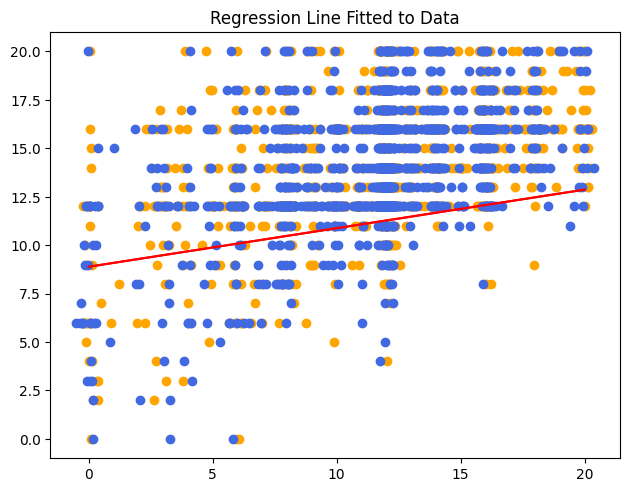

In [15]:
# Using model values to plot the slope
def plot():
    slope = ols_model.coefficients[0]
    intercept = ols_model.intercept  

    def linear_slope(x, intercept, slope):
        return (intercept) + (slope)*(x)

    X_plot = np.linspace(X.min(), X.max(), 2)
    y_plot = linear_slope(X_plot, intercept, slope)

    def jitter(values, noise=0.2):
        return values + np.random.normal(0, noise, size=len(values))

    plt.scatter(jitter(X['paeduc']), y, color="orange")
    plt.scatter(jitter(X['maeduc']), y, color="royalblue")
    plt.plot(X_plot, y_plot, color='red')
    plt.tight_layout()
    plt.title("Regression Line Fitted to Data")
    plt.show()

plot()

### Linear Model - Open Form, Learning Features via Gradient Descent

$$\widehat{y} = Xw + b$$

$w$: The values of the coefficient(s)

$b$: Scalar bias, model intercept.

Gradient Weights:
$$\frac{\partial J}{\partial w} = \frac{1}{n}X^T(\widehat{y}-y)$$

Gradient WRT Bias
$$\frac{\partial J}{\partial b} = \frac{1}{n}\sum^n_{i=1}(\widehat{y}-y)$$

$$$$

In [16]:
class LinearRegressionGradient:

    def __init__(self, learning_rate: float = 0.01, n_iters: int = 1000000) -> None:
        self.learning_rate, self.n_iters = learning_rate, n_iters
        self.coefficients, self.intercept = None, None # Initialized when fitting

    def fit(self, X, y):
            num_samples, num_features = X.shape   
            self.coefficients = np.random.rand(num_features)  
            self.intercept = 0

            for _ in range(self.n_iters): # Iterate to learn the coefficients

                y_pred = np.dot(X, self.coefficients) + self.intercept

                gradient_weights = (1 / num_samples) * np.dot(X.T, y_pred - y)
                gradient_wrt_bias = (1 / num_samples) * np.sum(y_pred - y)

                self.coefficients = self.coefficients - (self.learning_rate * gradient_weights)
                self.intercept = self.intercept - (self.learning_rate * gradient_wrt_bias)

            return self

    def predict(self, X):
        X = np.asarray(X, dtype=float)
        return X @ self.coefficients + self.intercept

In [17]:
gradient_model = LinearRegressionGradient(learning_rate=0.001).fit(X.values.reshape(-1,len(X.columns)),y)

print(f"Learned bias (β̂₀): {gradient_model.intercept:.4f}")
print(f"Learned coefficient (β̂₁): {gradient_model.coefficients[0]:.4f}")
print(f"Learned coefficient (β̂₁): {gradient_model.coefficients[1]:.4f}")

Learned bias (β̂₀): 8.8861
Learned coefficient (β̂₁): 0.1989
Learned coefficient (β̂₁): 0.2383


In [18]:
def predict():
    X_test = np.array([[0,0]])
    y_pred = gradient_model.predict(X_test)

    print("Predictions:")
    for (x, pred) in zip(X_test.flatten(), y_pred):
        print(f"X = {x:4.1f} → ŷ = {pred:.3f}")

predict()

Predictions:
X =  0.0 → ŷ = 8.886


In [19]:
def gradient_stats():
    predictions = gradient_model.predict(X.values.reshape(-1, len(gradient_model.coefficients)))
    residuals = (y-predictions)
    degrees_freedom = len(residuals) - (len(gradient_model.coefficients) + 1)

    SSR = np.sum(residuals**2)                           
    TSS = np.sum((y - np.mean(y))**2)                   
    ESS = np.sum((predictions - np.mean(y))**2)  

    r_squared_method1 = 1 - (SSR / TSS)
    r_squared_method2 = ESS / TSS

    MSE = SSR / len(residuals)
    RMSE = np.sqrt(MSE)

    MSE_DF = SSR / degrees_freedom
    RMSE_DF = np.sqrt(MSE_DF)

    print(f"Sum of Squared Residuals: {SSR:.4f}")
    print(f"Total Sum of Squares: {TSS:.4f}")
    print(f"Explained Sum of Squares: {ESS:.4f}\n")

    print(f"Mean Squared Error: {MSE:.4f}")
    print(f"Root Mean Squared Error: {RMSE:.4f}")

    print(f"Mean Squared Error 2 df: {MSE_DF:.4f}")
    print(f"Root Mean Squared Error 2 df: {RMSE_DF:.4f}\n")

    print(f"R² (method 1): {r_squared_method1:.4f}")
    print(f"R² (method 2): {r_squared_method2:.4f}")

    # Verify that hand done formulas are = to sm.api output.
    print(f"\nCheck: R^2 = statsmodels.api {r_squared_method2:.4f} ≈ {(sm_model.rsquared):.4f}")
    print(f"Check: MSE = statsmodels.api {MSE_DF:.4f} ≈ {(sm_model.mse_resid):.4f}")
    print(f"Check: RMSE = statsmodels.api {RMSE_DF:.4f} ≈ {np.sqrt(sm_model.mse_resid):.4f}")

gradient_stats()

Sum of Squared Residuals: 10115.9844
Total Sum of Squares: 13663.2707
Explained Sum of Squares: 3547.2863

Mean Squared Error: 7.2051
Root Mean Squared Error: 2.6842
Mean Squared Error 2 df: 7.2205
Root Mean Squared Error 2 df: 2.6871

R² (method 1): 0.2596
R² (method 2): 0.2596

Check: R^2 = statsmodels.api 0.2596 ≈ 0.2596
Check: MSE = statsmodels.api 7.2205 ≈ 7.2205
Check: RMSE = statsmodels.api 2.6871 ≈ 2.6871


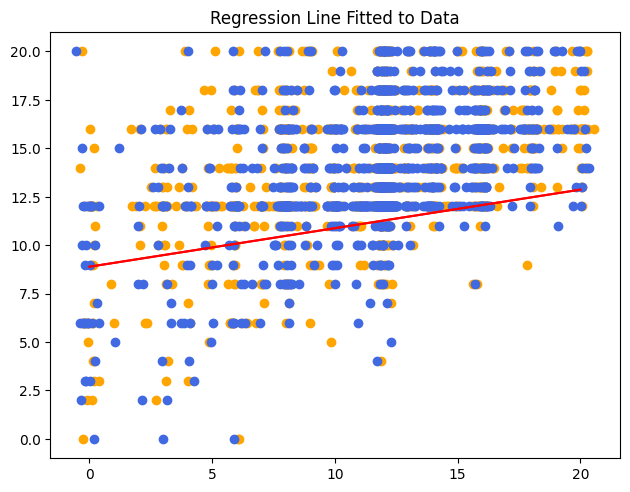

In [20]:
def plot():
    intercept = gradient_model.intercept
    slope = gradient_model.coefficients[0]

    def linear_slope(x, intercept, slope):
        return (intercept) + (slope)*(x)

    X_plot = np.linspace(X.min(), X.max(), 2)
    y_plot = linear_slope(X_plot, intercept, slope)

    def jitter(values, noise=0.2):
        return values + np.random.normal(0, noise, size=len(values))

    plt.scatter(jitter(X['paeduc']), y, color="orange")
    plt.scatter(jitter(X['maeduc']), y, color="royalblue")
    plt.plot(X_plot, y_plot, color='red')
    plt.tight_layout()
    plt.title("Regression Line Fitted to Data")
    plt.show()

plot()